# Reporting dashboard
## Transition frequencies


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
from IPython.display import display

import src.compute.changelogs as changelogs
import src.compute.developer as developer
from src.compute.utils import Interval
from src.db.utils import SnowflakeWrapper

conn = SnowflakeWrapper.create_snowflake_connection()
sw = SnowflakeWrapper(conn)

def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100
figure_size = (14, 12)

First, we need to define an interval in which we will operate:

In [16]:
active_interval: Interval = Interval(
    fromDate=date(2019, 7, 1), # year, month, day
    # toDate=date(2019, 10, 1),
    # fromDate=date(2019, 10, 1), # year, month, day
    toDate=date(2020, 1, 1)
)
print(active_interval)

('2019-07-01', '2020-01-01')


In [17]:
def draw_most_frequent_per_week(all_data: pd.DataFrame, max_by: pd.DataFrame, dimension:str, metric: str = "TotalTransitions"):
    fig, ax = plt.subplots(figsize=figure_size, dpi= 80, facecolor='w', edgecolor='k')
    max_y = -1
    for _, row in max_by.iterrows():
        data = all_data[all_data[dimension].isin([row[dimension]])]
        x_data = data["WeekOfYear"]
        y_data = data[metric]
        max_y = max(max(y_data), max_y)
        ax.plot(x_data, y_data, label=row[dimension])
        ax.plot(x_data, y_data, 'ro')
    
    ax.set_xlabel("Week")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Most Frequent by {dimension}")
    ax.set_yticks(range(0, max_y + 10, 5), minor=False)
    cols = int(len(max_by)/2)
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=cols)
    ax.grid()

Number of actions on the given interval

In [18]:
active_cards = changelogs.transition_frequency(sw, interval=active_interval, by_status=False, by_week=False)
print(f"Cards active in the interval {active_interval}: {active_cards['TotalTransitions'][0]}")

SELECT                         COUNT(*) "TotalTransitions" FROM CHANGELOGS C        WHERE     C.CHANGELOGITEM:field::string = 'status'     AND C.DATECREATED >= '2019-07-01' AND C.DATECREATED < '2020-01-01'  ORDER BY 1 DESC LIMIT 10; 
Cards active in the interval ('2019-07-01', '2020-01-01'): 13449


In [19]:
print(f"Number of transitions in the interval, by week:")
frequency_week = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_status=False, by_week=True, order="ASC")
display(frequency_week)

Number of transitions in the interval, by week:
SELECT     YEAR "Year", IFF(MONTH = 12 AND WEEKOFYEAR = 1, WEEKOFYEAR + 52, WEEKOFYEAR) "WeekOfYear",                    COUNT(*) "TotalTransitions" FROM CHANGELOGS C        WHERE     C.CHANGELOGITEM:field::string = 'status'     AND C.DATECREATED >= '2019-07-01' AND C.DATECREATED < '2020-01-01' GROUP BY 1,2 ORDER BY 1,2,3 ASC ; 


,Year,WeekOfYear,TotalTransitions
0,2019,27.00000,438
1,2019,28.00000,588
2,2019,29.00000,679
3,2019,30.00000,518
4,2019,31.00000,517
5,2019,32.00000,597
6,2019,33.00000,515
7,2019,34.00000,688
8,2019,35.00000,733
9,2019,36.00000,652


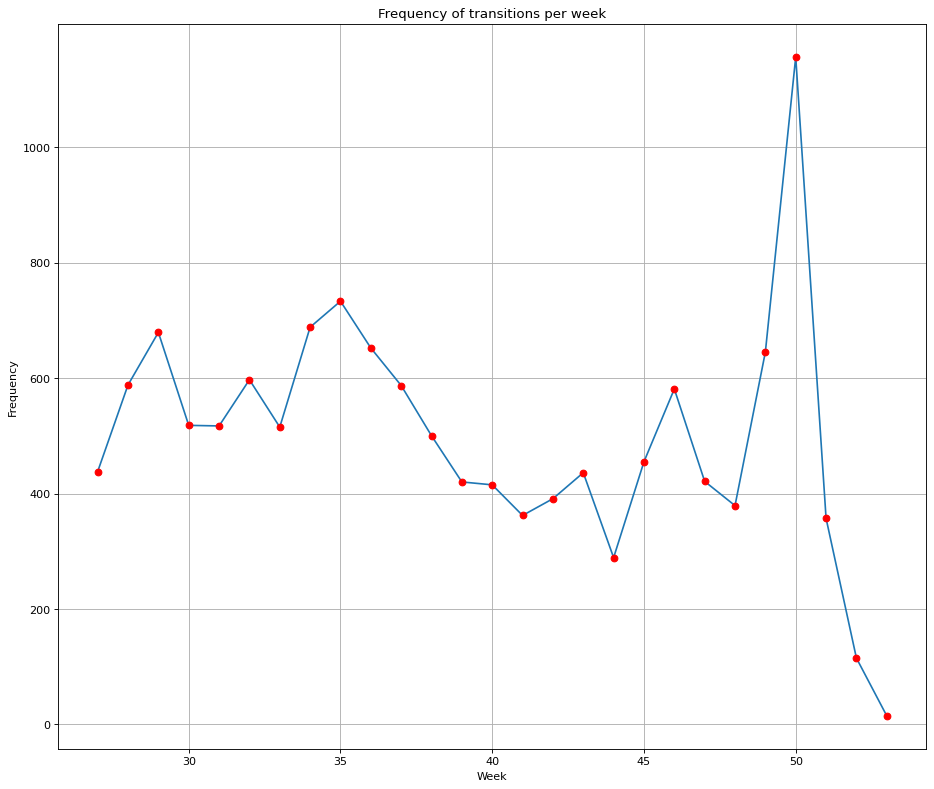

In [20]:
def draw_per_week():
    fig, ax = plt.subplots(figsize=figure_size, dpi= 80, facecolor='w', edgecolor='k')
    ax.set_xlabel("Week")
    ax.set_ylabel("Frequency")
    ax.set_title("Frequency of transitions per week")
    ax.grid()
    x_data = frequency_week["WeekOfYear"]
    y_data = frequency_week["TotalTransitions"]
    max_y = max(y_data)
    ax.plot(x_data, y_data)
    ax.plot(x_data, y_data, 'ro')
    ax.set_yticks(range(0, max_y + 10, roundup(int(max_y/10))), minor=False)
draw_per_week()

In [21]:
print(f"Most frequent transitions in the interval:")
most_frequent_transition = changelogs.transition_frequency(sw, interval=active_interval, limit=5, order="DESC")
display(most_frequent_transition)

# print(f"Least frequent transitions in the interval:")
# least_frequent = changelogs.transition_frequency(sw, interval=active_interval, limit=10, order="ASC")
# display(least_frequent)

Most frequent transitions in the interval:
SELECT                    CHANGELOGITEM:fromString::string  || ' -> ' || CHANGELOGITEM:toString::string "Transition",     COUNT(*) "TotalTransitions" FROM CHANGELOGS C        WHERE     C.CHANGELOGITEM:field::string = 'status'     AND C.DATECREATED >= '2019-07-01' AND C.DATECREATED < '2020-01-01' GROUP BY 1 ORDER BY 2 DESC LIMIT 5; 


,Transition,TotalTransitions
0,Ready for dev -> Development,1161
1,Development -> Code review,1081
2,Code review -> Testing,1038
3,Master -> Live,944
4,Testing -> Master,901


SELECT     YEAR "Year", IFF(MONTH = 12 AND WEEKOFYEAR = 1, WEEKOFYEAR + 52, WEEKOFYEAR) "WeekOfYear",               CHANGELOGITEM:fromString::string  || ' -> ' || CHANGELOGITEM:toString::string "Transition",     COUNT(*) "TotalTransitions" FROM CHANGELOGS C        WHERE     C.CHANGELOGITEM:field::string = 'status'     AND C.DATECREATED >= '2019-07-01' AND C.DATECREATED < '2020-01-01' GROUP BY 1,2,3 ORDER BY 1,2,3,4 ASC ; 


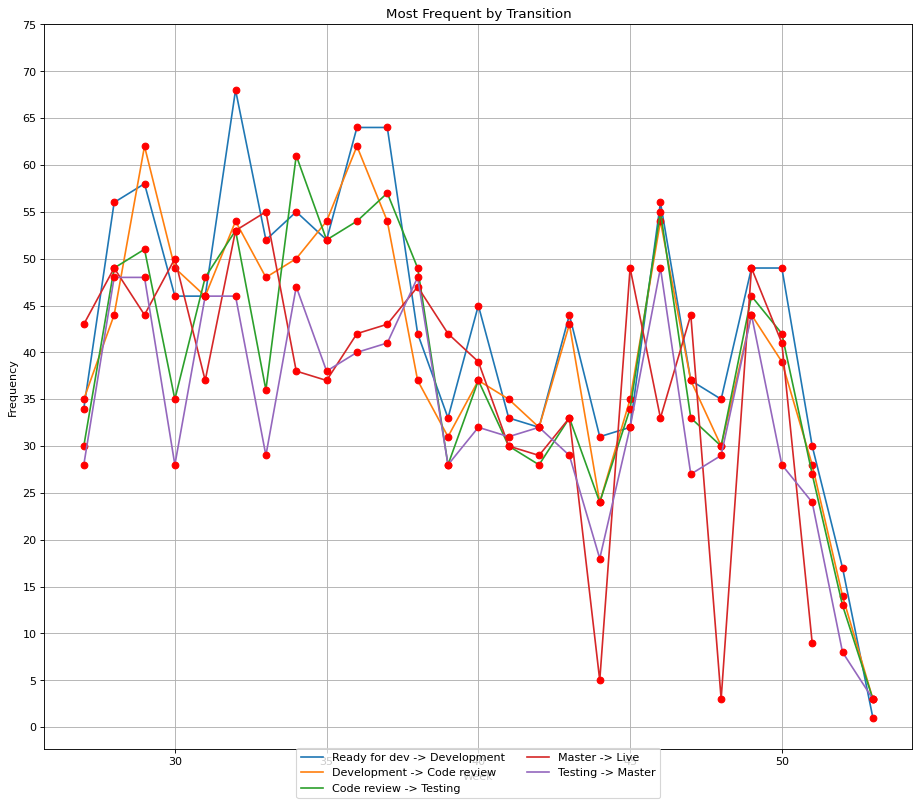

In [22]:
most_frequent_transition_week = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=True, order="ASC")
draw_most_frequent_per_week(most_frequent_transition_week, most_frequent_transition, "Transition")

In [23]:
most_frequent_type = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=False, by_issue_type=True, by_status=False, order="DESC")
display(most_frequent_type)
most_frequent_week_type = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=True, by_issue_type=True, by_status=False, order="DESC")
# display(most_frequent_week_type)

SELECT          I.FIELDS:issuetype:name "IssueType",               COUNT(*) "TotalTransitions" FROM CHANGELOGS C       INNER JOIN ISSUES I on C.KEY = I.KEY  WHERE     C.CHANGELOGITEM:field::string = 'status'     AND C.DATECREATED >= '2019-07-01' AND C.DATECREATED < '2020-01-01' GROUP BY 1 ORDER BY 2 DESC ; 
SELECT     YEAR "Year", IFF(MONTH = 12 AND WEEKOFYEAR = 1, WEEKOFYEAR + 52, WEEKOFYEAR) "WeekOfYear",     I.FIELDS:issuetype:name "IssueType",               COUNT(*) "TotalTransitions" FROM CHANGELOGS C       INNER JOIN ISSUES I on C.KEY = I.KEY  WHERE     C.CHANGELOGITEM:field::string = 'status'     AND C.DATECREATED >= '2019-07-01' AND C.DATECREATED < '2020-01-01' GROUP BY 1,2,3 ORDER BY 1,2,3,4 DESC ; 


,IssueType,TotalTransitions
0,"""Bug""",5134
1,"""Internal Improvement""",4221
2,"""New Feature or Improvement""",3134
3,"""Task""",384
4,"""Improvement (Sub-task)""",285
5,"""Epic""",197
6,"""Sub-task""",64
7,"""Prototype""",16
8,"""Bug (Sub-task)""",14


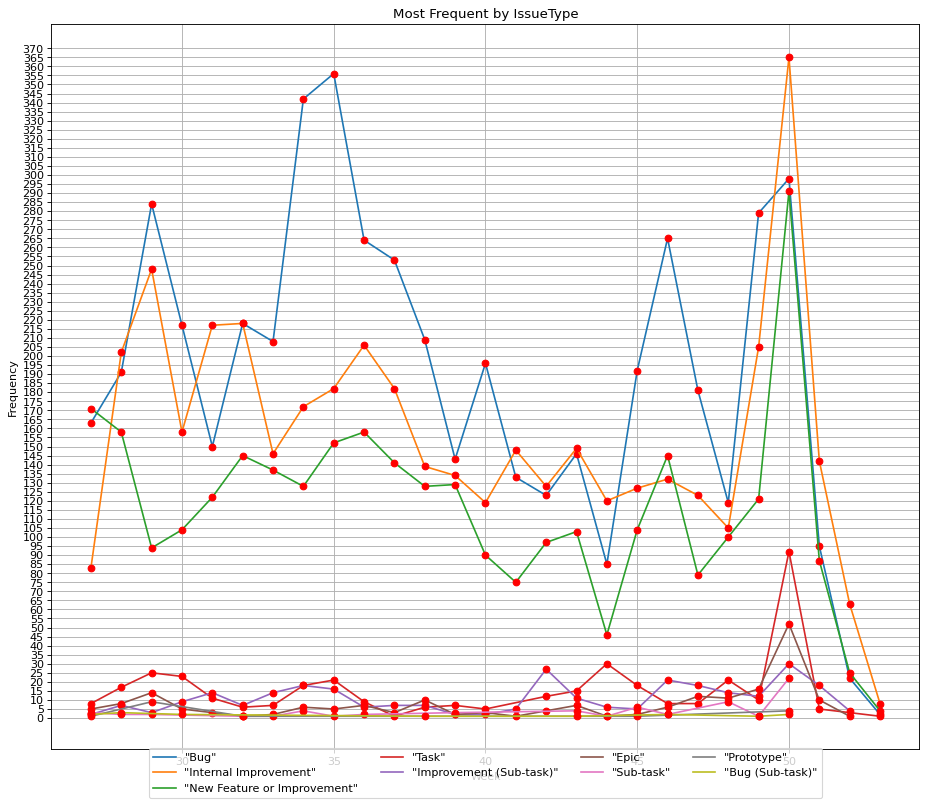

In [24]:
draw_most_frequent_per_week(most_frequent_week_type, most_frequent_type, "IssueType")

In [25]:
most_frequent_priority = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=False, by_issue_priority=True, by_issue_type=False, by_status=False, order="DESC")
display(most_frequent_priority)
most_frequent_week_priority = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=True, by_issue_priority=True, by_issue_type=False, by_status=False, order="DESC")
# display(most_frequent_week_priority)

SELECT               I.FIELDS:priority:name "IssuePriority",          COUNT(*) "TotalTransitions" FROM CHANGELOGS C       INNER JOIN ISSUES I on C.KEY = I.KEY  WHERE     C.CHANGELOGITEM:field::string = 'status'     AND C.DATECREATED >= '2019-07-01' AND C.DATECREATED < '2020-01-01' GROUP BY 1 ORDER BY 2 DESC ; 
SELECT     YEAR "Year", IFF(MONTH = 12 AND WEEKOFYEAR = 1, WEEKOFYEAR + 52, WEEKOFYEAR) "WeekOfYear",          I.FIELDS:priority:name "IssuePriority",          COUNT(*) "TotalTransitions" FROM CHANGELOGS C       INNER JOIN ISSUES I on C.KEY = I.KEY  WHERE     C.CHANGELOGITEM:field::string = 'status'     AND C.DATECREATED >= '2019-07-01' AND C.DATECREATED < '2020-01-01' GROUP BY 1,2,3 ORDER BY 1,2,3,4 DESC ; 


,IssuePriority,TotalTransitions
0,"""Major""",5838
1,"""Minor""",5833
2,"""Critical""",1081
3,"""Blocker""",492
4,"""Trivial""",205


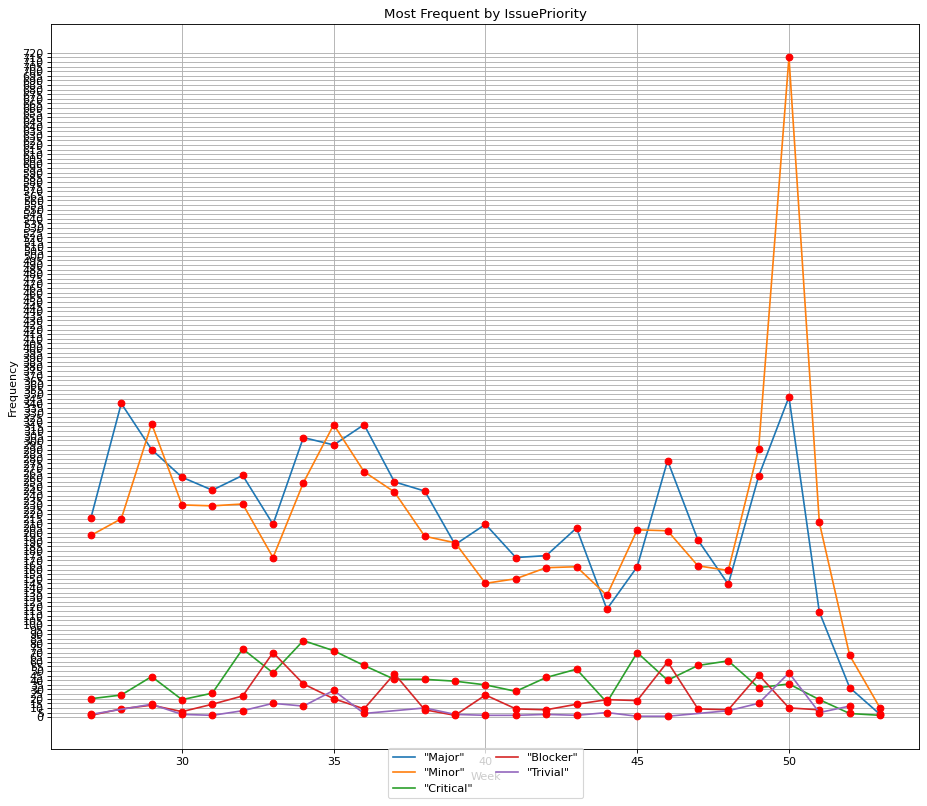

In [26]:
draw_most_frequent_per_week(most_frequent_week_priority, most_frequent_priority, "IssuePriority") 

In [27]:
authored_activity = developer.get_avg_authored_activity(sw, active_interval)
display(authored_activity.head(10))
# display(authored_activity.tail(10))

,count,mean,std,min,25%,50%,75%,max
status,116.0,115.939655,163.863108,0.0,2.75,38.0,189.25,854.0
assignee,116.0,57.387931,80.401360,0.0,2.00,22.0,80.50,405.0
description,116.0,55.120690,66.305768,0.0,3.00,31.0,79.00,316.0
labels,116.0,34.215517,77.475697,0.0,0.00,15.5,42.50,762.0
resolution,116.0,22.000000,27.558949,0.0,1.00,9.0,33.00,168.0
Link,116.0,16.715517,32.049094,0.0,0.00,6.0,18.00,258.0
Fix Version,116.0,9.517241,64.725707,0.0,0.00,0.0,0.00,645.0
duedate,116.0,8.250000,15.632672,0.0,0.00,2.0,11.00,109.0
Bugs & Issues,116.0,7.965517,32.078960,0.0,0.00,0.0,2.00,320.0
Epic Child,116.0,7.887931,17.494730,0.0,0.00,1.0,7.00,115.0


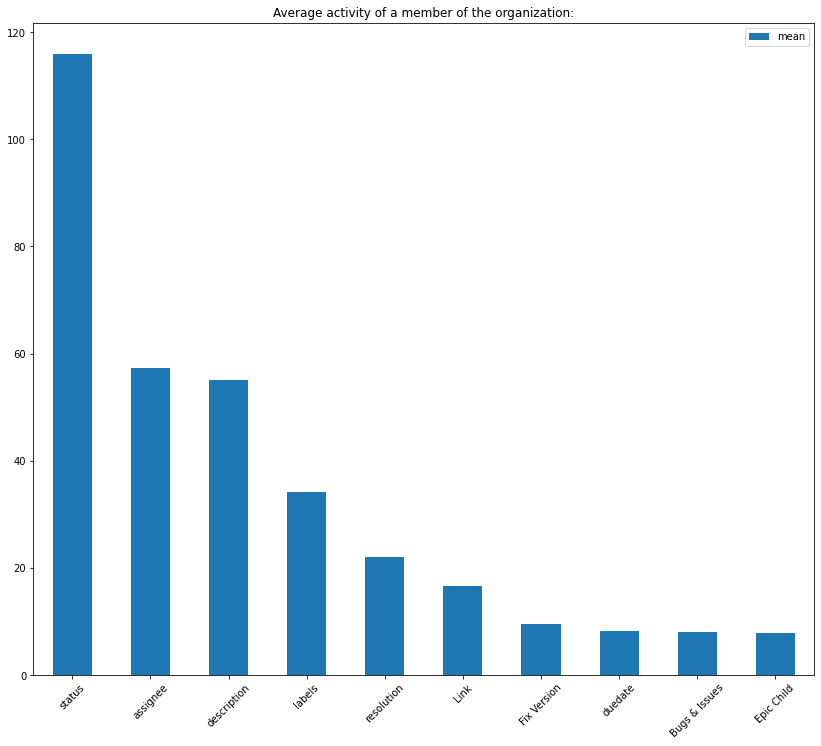

In [28]:
authored_activity.head(10).plot(kind='bar', use_index=True, y='mean', rot=45, figsize=figure_size, title="Average activity of a member of the organization:")